In [1]:
import os
import math
import numpy as np
import pandas as pd
from ast import literal_eval
from scipy.special import kl_div
import itertools
import arviz as az
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as  mpatches
pd.options.mode.chained_assignment = None  # default='warn'

from helper_functions import *
from metrics import get_dist_to_spaceship_fix_rest, get_dist_to_spaceship_fix_rest_multiple, get_dist_to_obstacles_fix_explore, get_dist_to_obstacles_fix_explore_multiple, get_dist_to_obstacles_sacc, get_dist_to_obstacles_sacc_multiple

In [2]:
drift_type_dict = {
    1: [['A', 'Right'], ['B', 'Left'], ['A', 'Right'], ['A', 'Right'], ['B', 'Right'], ['A', 'Right'], ['B', 'Left'], ['B', 'Right']],
    2: [['B', 'Left'], ['B', 'Left'], ['A', 'Right'], ['A', 'Left'], ['A', 'Left'], ['B', 'Left'], ['A', 'Right'], ['B', 'Right']],
    3: [['A', 'Left'], ['A', 'Right'], ['A', 'Left'], ['B', 'Right'], ['B', 'Right'], ['A', 'Left'], ['B', 'Right'], ['B', 'Left']],
    4: [['A', 'Left'], ['B', 'Right'], ['B', 'Left'], ['A', 'Right'], ['A', 'Right'], ['B', 'Left'], ['B', 'Left'], ['A', 'Right']],
    5: [['B', 'Right'], ['A', 'Left'], ['A', 'Left'], ['B', 'Right'], ['B', 'Left'], ['A', 'Right'], ['B', 'Right'], ['A', 'Left']],
    6: [['B', 'Left'], ['A', 'Right'], ['B', 'Left'], ['A', 'Right'], ['B', 'Right'], ['B', 'Left'], ['A', 'Left'], ['A', 'Right']]
}

# Input data & fixational data

In [3]:

example = pre_process_input_data(pd.read_csv(("../../../../Volumes/KMODyS_1/Data Moonlander II/UB02TZ/data/UB02TZ_output_6Bfake_done_40.csv"), index_col=False))


In [4]:
example.columns

Index(['frame', 'trial', 'attempt', 'time_played', 'time_tag', 'level_size_y',
       'player_pos', 'collision', 'current_input', 'current_drift',
       'drift_variation', 'drift_type', 'level_done', 'visible_obstacles',
       'last_walls_tile', 'adjacent_wall_tiles_x_pos', 'visible_drift_tiles',
       'expectability', 'SoC', 'adjusted_time_tag', 'start_input', 'N_input',
       'input_change', 'input_duration', 'drift_tile_onset',
       'drift_effect_onset'],
      dtype='object')

In [14]:
data_dir = "../../../../Volumes/KMODyS_1/Data Moonlander II/"
done_string = "done"

successfull_runs = []

for subdir, dirs, files in os.walk(data_dir):
    for file in files:
        if done_string in file:
            successfull_runs.append(file)
successfull_runs

['UB02TZ_output_6Bfake_done_40.csv',
 'UB02TZ_output_1Afake_done_37.csv',
 'UB02TZ_output_4Binvisible_done_25.csv',
 'UB02TZ_output_1Ainvisible_done_21.csv',
 'UB02TZ_output_6Afake_done_38.csv',
 'UB02TZ_output_1Ano_drift_done_09.csv',
 'UB02TZ_output_2Bno_drift_done_03.csv',
 'UB02TZ_output_5Afake_done_34.csv',
 'UB02TZ_output_1Bno_drift_done_30.csv',
 'UB02TZ_output_6Ainvisible_done_16.csv',
 'UB02TZ_output_3Bfake_done_36.csv',
 'UB02TZ_output_6Bno_drift_done_06.csv',
 'UB02TZ_output_2Bfake_done_33.csv',
 'UB02TZ_output_4Afake_done_31.csv',
 'UB02TZ_output_12ANone_done_02.csv',
 'UB02TZ_output_6Ano_drift_done_29.csv',
 'UB02TZ_output_5Ainvisible_done_27.csv',
 'UB02TZ_output_2Ainvisible_done_15.csv',
 'UB02TZ_output_4Bfake_done_43.csv',
 'UB02TZ_output_2Binvisible_done_14.csv',
 'UB02TZ_output_5Bfake_done_35.csv',
 'UB02TZ_output_2Ano_drift_done_46.csv',
 'UB02TZ_output_11ANone_done_01.csv',
 'UB02TZ_output_5Ano_drift_done_05.csv',
 'UB02TZ_output_3Ano_drift_done_08.csv',
 'UB02TZ_ou

In [23]:
drift_situation_input_data = pd.DataFrame()
drift_situation_fixations = pd.DataFrame()

for successfull_run in successfull_runs:
    
    if "None" not in successfull_run:  # don't know what these are, but guessing normal trials in between blocks...
        
        tmp = successfull_run.split('_')
        id = tmp[0]
        run = tmp[-1][:2]
        triplet = tmp[2]
        level = int(triplet[:1])
        drift_type = triplet[1:2]
        drift_condition = triplet[2:]
    
        tmp_data = pre_process_input_data(pd.read_csv((f"../../../../Volumes/KMODyS_1/Data Moonlander II/{id}/data/{successfull_run}"), index_col=False))
                                          
        tmp_data['N_drift'] = (tmp_data['drift_tile_onset']==1).cumsum()
        tmp_data.loc[tmp_data.drift_tile_onset < 1.0, "N_drift"] = np.nan
                        
        tmp_data['individual_drift_tile_variation'] = pd.Series(dtype='int')
        tmp_data['individual_drift_tile_direction'] = pd.Series(dtype='str')

        for index, row in tmp_data.iterrows():
            if row['drift_tile_onset'] == 1:

                tmp_data.at[index,'individual_drift_tile_variation'] = drift_type_dict[level][int(row.N_drift)-1][0]
                tmp_data.at[index,'individual_drift_tile_direction'] = drift_type_dict[level][int(row.N_drift)-1][1]
            else:
                tmp_data.at[index,'individual_drift_tile_variation'] = np.nan
                tmp_data.at[index,'individual_drift_tile_direction'] = np.nan
    
        
        tmp_drift_onset_time_stamps = tmp_data.loc[tmp_data.drift_tile_onset == 1].time_played
        
        # read in eye_data
        if triplet[-1] == 'o':
            eye_data_path = f'{data_dir}{id}/eye_data/{id}_eye_tracking_output_{triplet}_drift_{run}.csv'
        else:
            eye_data_path = f'{data_dir}{id}/eye_data/{id}_eye_tracking_output_{triplet}_{run}.csv'
        
        tmp_eye_data = pre_process_eye_data(pd.read_csv((f"{tmp_path}"), index_col=False))
        tmp_eye_data['level'] = level
        tmp_eye_data['drift_variation'] = drift_type
        tmp_eye_data['block_type'] = drift_condition
        tmp_eye_data['run'] = run
        
        
        for time_stamp in tmp_drift_onset_time_stamps:
            tmp_drift_situation_input_data = tmp_data[tmp_data.time_played.between(time_stamp-0.01, time_stamp+2.45)]
            # 2.45 correct? might be too long, so we might end up with input AFTER drifts
            
            if tmp_drift_situation_input_data.individual_drift_tile_variation.iloc[0] is not drift_type:  # the interesting situations are the ones with normal drift
                tmp_drift_situation_input_data.individual_drift_tile_variation = tmp_drift_situation_input_data.individual_drift_tile_variation.iloc[0]
                tmp_drift_situation_input_data.individual_drift_tile_direction = tmp_drift_situation_input_data.individual_drift_tile_direction.iloc[0]


                drift_situation_input_data = pd.concat([drift_situation_input_data, tmp_drift_situation_input_data])
                
                # eye_data
                tmp_drift_situation_eye_data = tmp_eye_data[tmp_eye_data.time_tag.between(time_stamp-0.01, time_stamp+2.45)]
                tmp_drift_situation_fixations = tmp_drift_situation_eye_data[tmp_drift_situation_eye_data.fixationOnset == 1]
                
                drift_situation_fixations = pd.concat([drift_situation_fixations, tmp_drift_situation_fixations])
            
          

In [86]:
drift_situation_input_data

,frame,trial,attempt,time_played,time_tag,level_size_y,player_pos,collision,current_input,current_drift,...,start_input,N_input,input_change,input_duration,drift_tile_onset,second_drift_tile_onset,drift_onset,N_drift,individual_drift_tile_variation,individual_drift_tile_direction
526,526,6,2,9.208380,7836.223251,14094,"[954, 270]",False,NaN,0.0,...,NaN,NaN,NaN,NaN,1,0,1,2.0,A,Right
527,527,6,2,9.228325,7836.223251,14094,"[954, 270]",False,NaN,0.0,...,NaN,NaN,NaN,NaN,0,0,0,NaN,A,Right
528,528,6,2,9.245307,7836.223251,14094,"[954, 270]",False,NaN,0.0,...,NaN,NaN,NaN,NaN,0,0,0,NaN,A,Right
529,529,6,2,9.264246,7836.223251,14094,"[954, 270]",False,NaN,0.0,...,NaN,NaN,NaN,NaN,0,0,0,NaN,A,Right
530,530,6,2,9.281528,7836.223251,14094,"[954, 270]",False,NaN,0.0,...,NaN,NaN,NaN,NaN,0,0,0,NaN,A,Right
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1797,1797,6,1,31.669975,2426.732586,14094,"[954, 270]",False,Left,-0.5,...,0.0,17.0,NaN,0.689469,0,0,0,NaN,B,Left
1798,1798,6,1,31.685782,2426.732586,14094,"[954, 270]",False,Left,0.0,...,0.0,17.0,NaN,0.689469,0,0,0,NaN,B,Left
1799,1799,6,1,31.706731,2426.732586,14094,"[954, 270]",False,Left,0.0,...,0.0,17.0,NaN,0.689469,0,0,0,NaN,B,Left
1800,1800,6,1,31.723712,2426.732586,14094,"[954, 270]",False,Left,0.0,...,0.0,17.0,NaN,0.689469,0,0,0,NaN,B,Left


In [11]:
#drift_situation_input_data.to_csv('drift_situation_input_data.csv', index=False, sep=',')

#drift_situation_fixations.to_csv('drift_situation_fixations.csv', index=False, sep=',')

In [38]:
drift_situation_input_data = pd.read_csv('moonlander_ii_drift_situations/drift_situation_input_data.csv', index_col=False)

drift_situation_inputs = drift_situation_input_data.copy()

In [13]:
cond = (drift_situation_inputs.start_input == 1.0) & (drift_situation_inputs.current_drift == 0.0)
drift_situation_inputs["input_before_drift"] = np.where(cond, 1, 0)

In [14]:
inputs_before_drift = drift_situation_inputs.loc[drift_situation_inputs.input_before_drift == 1.0]

In [15]:
inputs_before_drift

,frame,trial,attempt,time_played,time_tag,level_size_y,player_pos,collision,current_input,current_drift,...,N_input,input_change,input_duration,drift_tile_onset,second_drift_tile_onset,drift_onset,N_drift,individual_drift_tile_variation,individual_drift_tile_direction,input_before_drift
73,599,6,2,10.482668,7836.223251,14094,"[954, 270]",False,Right,0.0,...,3.0,0.0,0.087925,0,0,0,NaN,A,Right,1
215,1021,6,2,18.001853,7836.223251,14094,"[954, 270]",False,Right,0.0,...,8.0,1.0,0.033246,0,0,0,NaN,A,Right,1
355,1869,6,2,33.043170,7836.223251,14094,"[954, 270]",False,Left,0.0,...,16.0,1.0,0.406919,0,0,0,NaN,A,Left,1
550,2113,6,2,37.405716,7836.223251,14094,"[954, 270]",False,Right,0.0,...,20.0,0.0,0.068439,0,0,0,NaN,A,Right,1
608,774,1,1,13.531333,7664.900431,14094,"[954, 270]",False,Left,0.0,...,7.0,1.0,0.227091,0,0,0,NaN,B,Left,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311112,1643,1,1,29.059270,2546.738138,14094,"[954, 270]",False,Left,0.0,...,21.0,0.0,0.143334,0,0,0,NaN,B,Left,1
311423,298,6,1,5.222738,2426.732586,14094,"[954, 270]",False,Right,0.0,...,1.0,1.0,0.261996,0,0,0,NaN,B,Left,1
311628,831,6,1,14.687604,2426.732586,14094,"[954, 270]",False,Right,0.0,...,6.0,1.0,0.200389,0,0,0,NaN,B,Left,1
311668,1284,6,1,22.607802,2426.732586,14094,"[954, 270]",False,Right,0.0,...,12.0,1.0,0.655919,0,0,0,NaN,B,Right,1


In [16]:
cond = (inputs_before_drift.current_input is not inputs_before_drift.individual_drift_tile_direction)
inputs_before_drift["input_countering_drift"] = np.where(cond, 1, 0)

In [19]:
#inputs_before_drift.to_csv('inputs_before_drift.csv', index=False, sep=',')

inputs_before_drift = pd.read_csv("moonlander_ii_drift_situations/inputs_before_drift.csv", index_col=False)

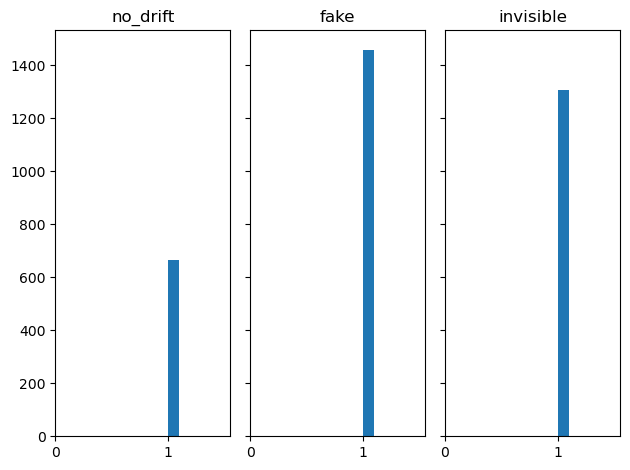

In [37]:
#inputs_before_drift.hist(column='input_countering_drift', by='drift_type')

fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True)

for i, block_type in enumerate(['no_drift', 'fake', 'invisible']):

    axs[i].hist(inputs_before_drift[inputs_before_drift.drift_type==block_type].input_countering_drift, align='mid')
    axs[i].set_xticks([0, 1])
    axs[i].set_title(block_type)

plt.show()

In [30]:
np.unique(inputs_before_drift["input_countering_drift"])

array([1])

Uff... it seems like input given prior to drift (in anticipation of drift) were ALWAYS contrary to the drift direction. There is no variance in there, therefore no effect of drift_type within the block etc.

# Fixational eye-movement analysis

In [9]:
drift_situation_fixations = pd.read_csv('moonlander_ii_drift_situations/drift_situation_fixations.csv', index_col=False)

drift_situation_fixations

,time_tag,TimeTag,LeftEyeX,LeftEyeY,LeftPupilDiameter,RightEyeX,RightEyeY,RightPupilDiameter,DigitalIn,LeftBlink,...,saccadeOnset,N_saccade,saccade_direction_x,saccade_direction_y,saccade_amplitude_in_pixel,saccade_amplitude,level,drift_variation,block_type,run
0,9.4225,7272.2945,-44.367004,198.045166,91.042969,173.234985,258.087524,84.800781,16777215.0,0.0,...,0,NaN,NaN,NaN,944.473739,NaN,6,B,fake,40
1,9.6300,7272.5020,-37.601562,208.673950,91.949219,213.777832,63.145630,84.824219,16777215.0,0.0,...,0,NaN,NaN,NaN,944.473739,NaN,6,B,fake,40
2,10.2900,7273.1620,-28.864258,209.253784,90.902344,34.671631,241.280273,91.132812,16777215.0,0.0,...,0,NaN,NaN,NaN,944.473739,NaN,6,B,fake,40
3,10.4635,7273.3355,-31.229370,207.598999,90.585938,35.322998,247.045776,91.660156,16777215.0,0.0,...,0,NaN,NaN,NaN,944.473739,NaN,6,B,fake,40
4,10.5275,7273.3995,-31.528931,201.432129,90.355469,-24.450256,239.245483,93.496094,16777215.0,0.0,...,0,NaN,NaN,NaN,944.473739,NaN,6,B,fake,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25092,30.9360,7293.8080,-33.319092,198.003906,92.062500,9.447754,282.639893,91.671875,16777215.0,0.0,...,0,NaN,NaN,NaN,944.473739,NaN,6,A,fake,36
25093,31.1345,7294.0065,33.527405,60.595093,91.648438,82.540955,67.859497,90.621094,16777215.0,0.0,...,0,NaN,NaN,NaN,944.473739,NaN,6,A,fake,36
25094,31.2645,7294.1365,15.292175,93.561646,91.828125,32.382812,109.788330,92.214844,16777215.0,0.0,...,0,NaN,NaN,NaN,944.473739,NaN,6,A,fake,36
25095,31.3500,7294.2220,-28.577820,122.947998,91.167969,22.309448,159.340698,91.722656,16777215.0,0.0,...,0,NaN,NaN,NaN,944.473739,NaN,6,A,fake,36


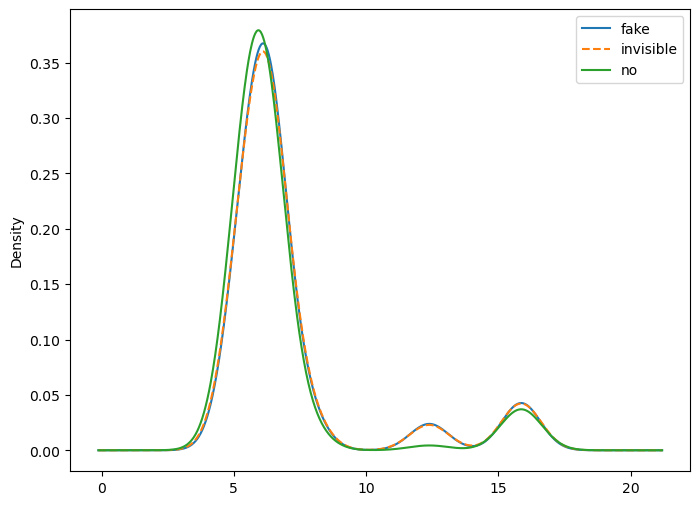

In [8]:

fig, ax = plt.subplots(figsize=(8,6))
for label, df in drift_situation_fixations[drift_situation_fixations.exploring_fixation == 1].groupby('block_type'):
    if label == "invisible":
        df.distance_to_spaceship.plot(kind="kde", ax=ax, label=label, linestyle="dashed")
    else:
        df.distance_to_spaceship.plot(kind="kde", ax=ax, label=label)
plt.legend()

Damn... even for eye-movement data it seems like fixations initiated prior to drift (in anticipation of drift) don't elicit varying statistics (distances to the spaceship) depending in the different block types. The density functions all look roughly the same.